<a href="https://colab.research.google.com/github/NeilAdel/Market-Basket-Analysis-on-LinkedIn-Job-Descriptions/blob/main/MarketBasketAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis on linkedIn Job Descriptions
Step 1: Installing required packages and setting up environments

In [1]:
# Install Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,089 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,523 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 http://security.ubun

In [2]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

In [3]:
!pip install -q pyspark==3.2.0
!pip install -q mlxtend
!pip install findspark
!pip install wordcloud
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 17.3 MB/s eta 0:00:00


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
os.environ["PATH"] += ":/content/spark-3.2.0-bin-hadoop3.2/bin:/content/spark-3.2.0-bin-hadoop3.2/sbin"


In [5]:
#starting the spark session
import findspark
from pyspark.sql import SparkSession
findspark.init()


spark = SparkSession.builder \
    .appName("MarketBasketAnalysis") \
    .config("spark.driver.memory", "60g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

In [6]:
spark

Step 2: Importing the dataset

In [7]:
# Access Kaggle
os.environ['KAGGLE_USERNAME'] = "xxxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxx"
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024


Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.87G/1.88G [00:31<00:00, 57.0MB/s]
100% 1.88G/1.88G [00:31<00:00, 63.9MB/s]


In [8]:
# Unzip the dataset
!unzip -q 1-3m-linkedin-jobs-and-skills-2024.zip
# Load the dataset into Spark DataFrame
df = spark.read.option("header", "true").csv("job_skills.csv")

df.show(10)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
+--------------------+--------------------+
only showing top 10 rows



In [9]:
import time
from datetime import datetime

# Defining a function to print time of running each block of code
def timing_info(start_time, step_name):
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    start_time_str = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print(f"{step_name} time: {int(minutes)}min {int(seconds)}s (started: {start_time_str})")

Step 3 : Preprocessing the dataset

In [10]:
import string
import re
import nltk
from nltk.corpus import stopwords
from pyspark.sql.functions import udf, col, split
from pyspark.sql.types import ArrayType, StringType

nltk.download('stopwords')



# Split the job_skills column by ', ' to create the skills column
df = df.withColumn("skills", split(col("job_skills"), ", "))

# Set up additional stopwords and initialize nltk stopwords
additional_stopwords = {"''", "...", "``", "--"}
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

def preprocess_skills(skills):
    if skills is None:
        return []

    punctuation = string.punctuation + "–"
    cleaned_skills = []

    for skill in skills:
        # Split skill by standalone "and" to process each part separately
        skill_parts = re.split(r'\band\b', skill)
        # Split multi-word skills into parts and processing them seperately
        for part in skill_parts:

            part = ''.join([char for char in part if char not in punctuation])
            part = part.lower()
            part = re.sub(r'[^a-z\s]', '', part)
            part = re.sub(r'\s+', ' ', part).strip()
            tokens = part.split()
            tokens = [word for word in tokens if word not in stop_words and re.match("^[a-zA-Z]+$", word)]

            cleaned_skill = " ".join(tokens).strip()
            # Only keep non-empty cleaned skills
            if cleaned_skill:
                cleaned_skills.append(cleaned_skill)

    return cleaned_skills

preprocess_skills_udf = udf(preprocess_skills, ArrayType(StringType()))


df = df.withColumn("cleaned_skills", preprocess_skills_udf(col("skills")))
df = df.filter(df.cleaned_skills.isNotNull())
df.show(10, truncate=False)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Step 4: Create a Resilient Distributed Dataset (RDD)

In [11]:
start_time = time.time()
df2 = df.sample(fraction=0.1, seed=42)

skills_rdd = df2.select("cleaned_skills").rdd.flatMap(list)
small_skills_list = skills_rdd.sample(False, 0.1, seed=42).collect()

timing_info(start_time, "Sampling the dataset and Creating RDD")

Sampling the dataset and Creating RDD time: 20min 37s (started: 2024-06-11 08:53:57)


Step 5: Main Analysis

# 1. Apriori Algorithm

**1-1. The first and second pass of Apriori algorithm**

In [12]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

start_time = time.time()

#Convert the skills into a binary matrix
encoded_skills = TransactionEncoder().fit(small_skills_list).transform(small_skills_list)

cols = TransactionEncoder().fit(small_skills_list).columns_
df_encoded = pd.DataFrame(encoded_skills, columns= cols)
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Calculate the count of each itemset
total_transactions = len(small_skills_list)
frequent_itemsets_apriori['count'] = (frequent_itemsets_apriori['support'] * total_transactions).round().astype(int)

print(frequent_itemsets_apriori)
timing_info(start_time, "Apply Apriori algorithm")


      support                                           itemsets  count
0    0.014006               (ability work fastpaced environment)    180
1    0.022954                       (ability work independently)    295
2    0.011282                            (ability work pressure)    145
3    0.012449                               (account management)    160
4    0.030423                                       (accounting)    391
..        ...                                                ...    ...
646  0.013383  (teamwork, leadership, time management, commun...    172
647  0.011594    (teamwork, leadership, training, communication)    149
648  0.010971  (teamwork, problem solving, time management, c...    141
649  0.015017  (communication, teamwork, time management, pro...    193
650  0.010349  (customer service, teamwork, time management, ...    133

[651 rows x 3 columns]
Apply Apriori algorithm time: 0min 41s (started: 2024-06-11 09:14:37)


**1-2. Association rules mining**

In [13]:
from mlxtend.frequent_patterns import association_rules
# Generate the association rules
rules = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.5)

# Add the count column
rules["antecedent_count"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequent_count"] = rules["consequents"].apply(lambda x: len(x))

rules_df = pd.DataFrame(rules).sort_values(by='confidence', ascending=False).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**1-3. Plotting the Association rules**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


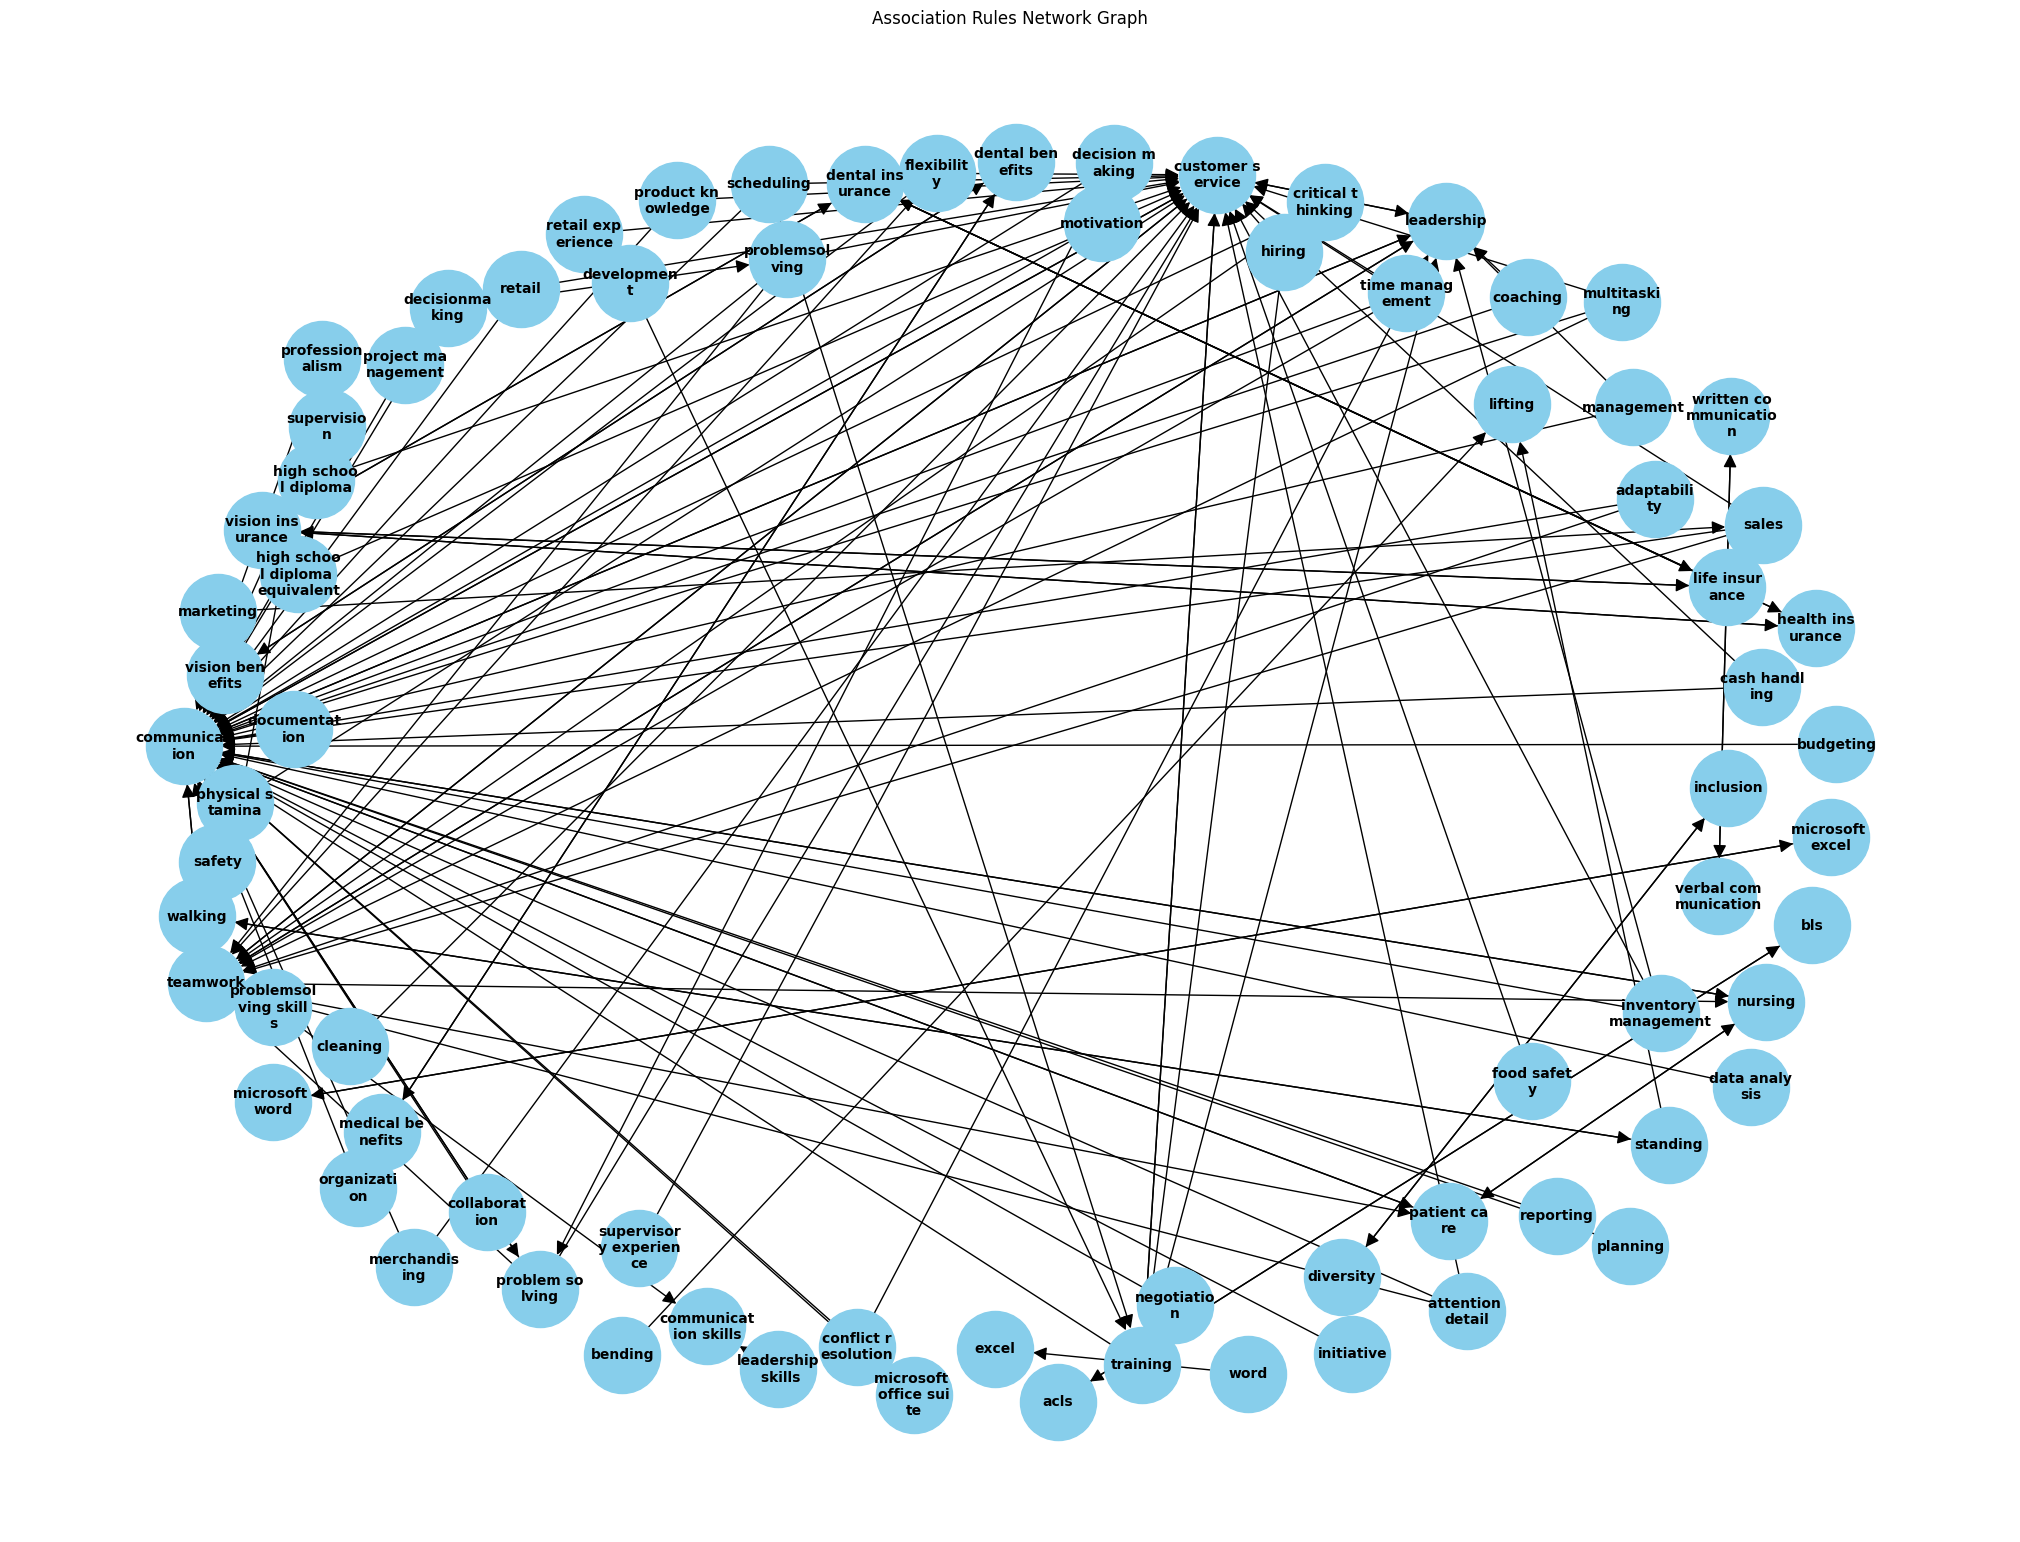

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Helper function to wrap text
def wrap_text(text, width=10):
    return '\n'.join(text[i:i+width] for i in range(0, len(text), width))

# Create a directed graph
G = nx.DiGraph()

# Add edges
for _, row in rules_df.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(wrap_text(antecedent), wrap_text(consequent))

# Draw the graph
pos = nx.spring_layout(G, k=3, iterations=50)
plt.figure(figsize=(20, 15))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Association Rules Network Graph")
plt.show()


**1-4. Saving the final results**

In [25]:
from google.colab import files

# Convert frozensets to strings
frequent_itemsets_apriori['itemsets'] = frequent_itemsets_apriori['itemsets'].apply(lambda x: '{' + ', '.join(list(x)) + '}')
rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x: '{' + ', '.join(list(x)) + '}')
rules_df['consequents'] = rules_df['consequents'].apply(lambda x: '{' + ', '.join(list(x)) + '}')

csv_file_path = '/content/frequent_itemsets_Apriori.csv'
frequent_itemsets_apriori.to_csv(csv_file_path, index=False)
rules_df.to_csv('/content/Association_rules_Apriori.csv', index=False)

# Download the CSV files
files.download(csv_file_path)
files.download('/content/Association_rules_Apriori.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**1-5. Plotting the word cloud for skills**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


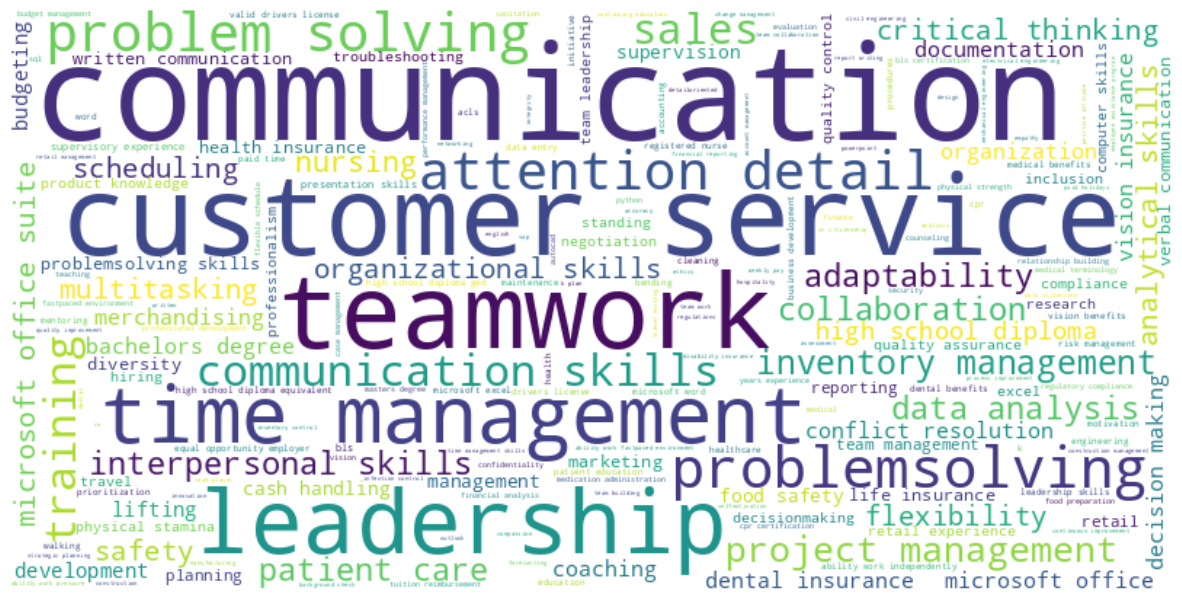

In [18]:
from wordcloud import WordCloud

frequent_itemsets_apriori_df = pd.read_csv(csv_file_path)

# Extract word counts
word_counts = {}
for _, row in frequent_itemsets_apriori_df.iterrows():
    itemset = row['itemsets'].strip('{}').split(', ')
    count = row['count']
    for item in itemset:
        if item in word_counts:
            word_counts[item] += count
        else:
            word_counts[item] = count


wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 2. Multistage Algorithm

**2-1. First pass of multistage algorithm**

In [19]:
import hashlib
from collections import defaultdict




# Initializiation
item_counts = defaultdict(int)
num_buckets = 10000 // 2 #2 is number of hash tables
bucket_counts_list = [defaultdict(int) for _ in range(2)]
support_threshold = 100

# First pass: Count item frequencies and bucket counts using multiple hash functions
start_time = time.time()
for basket in small_skills_list:
    for item in basket:
        item_counts[item] += 1
    for i in range(len(basket)):
        for j in range(i + 1, len(basket)):
            pair = (basket[i], basket[j])
            for k in range(2):
                bucket = int(hashlib.md5(str(pair).encode() + str(k).encode()).hexdigest(), 16) % num_buckets
                bucket_counts_list[k][bucket] += 1

# Identify frequent items and buckets
frequent_items = set(item for item, count in item_counts.items() if count >= support_threshold)
frequent_buckets_list = [set(bucket for bucket, count in bucket_counts.items() if count >= support_threshold) for bucket_counts in bucket_counts_list]

# Create the first bitmap for frequent buckets
bitmaps = []
for bucket_counts in bucket_counts_list:
    bitmap = [0] * num_buckets
    for bucket in bucket_counts:
        if bucket_counts[bucket] >= support_threshold:
            bitmap[bucket] = 1
    bitmaps.append(bitmap)

timing_info(start_time, "First pass of Multistage algorithm")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First pass of Multistage algorithm time: 0min 29s (started: 2024-06-11 09:35:19)


**2-2. Second pass of multistage algorithm**

In [20]:
# Second pass: Hash candidate pairs to the second hash table
start_time = time.time()
second_bucket_counts = defaultdict(int)
for basket in small_skills_list:
    frequent_basket_items = [item for item in basket if item in frequent_items]
    for i in range(len(frequent_basket_items)):
        for j in range(i + 1, len(frequent_basket_items)):
            pair = (frequent_basket_items[i], frequent_basket_items[j])
            if all(bitmaps[k][int(hashlib.md5(str(pair).encode() + str(k).encode()).hexdigest(), 16) % num_buckets] for k in range(2)):
                bucket = int(hashlib.sha256(str(pair).encode()).hexdigest(), 16) % num_buckets
                second_bucket_counts[bucket] += 1

# Create bitmap for second frequent buckets
second_bitmap = [0] * num_buckets
for bucket in second_bucket_counts:
    if second_bucket_counts[bucket] >= support_threshold:
        second_bitmap[bucket] = 1

timing_info(start_time, "Second pass of Multistage algorithm")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Second pass of Multistage algorithm time: 0min 4s (started: 2024-06-11 09:35:49)


**2-3. Third pass of multistage algorithm**

In [21]:
# Third pass: Count candidate pairs
start_time = time.time()
candidate_itemset_counts = defaultdict(int)
for basket in small_skills_list:
    frequent_basket_items = [item for item in basket if item in frequent_items]
    for i in range(len(frequent_basket_items)):
        for j in range(i + 1, len(frequent_basket_items)):
            pair = (frequent_basket_items[i], frequent_basket_items[j])
            bucket1 = int(hashlib.md5(str(pair).encode()).hexdigest(), 16) % num_buckets
            bucket2 = int(hashlib.sha256(str(pair).encode()).hexdigest(), 16) % num_buckets
            if bitmaps[0][bucket1] and second_bitmap[bucket2]:
                candidate_itemset_counts[pair] += 1

# Identify frequent pairs
frequent_itemsets_Multistage = {itemset: count for itemset, count in candidate_itemset_counts.items() if count >= support_threshold}


total_baskets = len(small_skills_list)

# Convert the frequent itemsets to a dataframe
frequent_itemsets_Multistage_df = pd.DataFrame([
    {'itemset': set(itemset), 'count': count, 'support': count / total_baskets}
    for itemset, count in frequent_itemsets_Multistage.items()
])

print(frequent_itemsets_Multistage_df)

timing_info(start_time, "Third pass of Multistage algorithm")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                               itemset  count   support
0             {customer service, communication skills}    411  0.031979
1            {organizational skills, customer service}    159  0.012372
2            {customer service, problemsolving skills}    107  0.008326
3       {customer service, ability work independently}    126  0.009804
4    {customer service, ability work fastpaced envi...    114  0.008870
..                                                 ...    ...       ...
330                           {scheduling, leadership}    111  0.008637
331                {customer service, problem solving}    106  0.008248
332                    {collaboration, problemsolving}    110  0.008559
333                        {leadership, collaboration}    120  0.009337
334                        {problem solving, training}    112  0.008715

[335 rows x 3 columns]
Third pass of Multistage algorithm time: 0min 3s (started: 2024-06-11 09:35:53)


**2-4. Saving the final results**

In [22]:
csv_file_path2 = '/content/frequent_itemsets_multistage.csv'
frequent_itemsets_Multistage_df.to_csv(csv_file_path2, index=False)

# Download the CSV file
files.download(csv_file_path2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**2-5. Plotting the word cloud for frequent skills**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


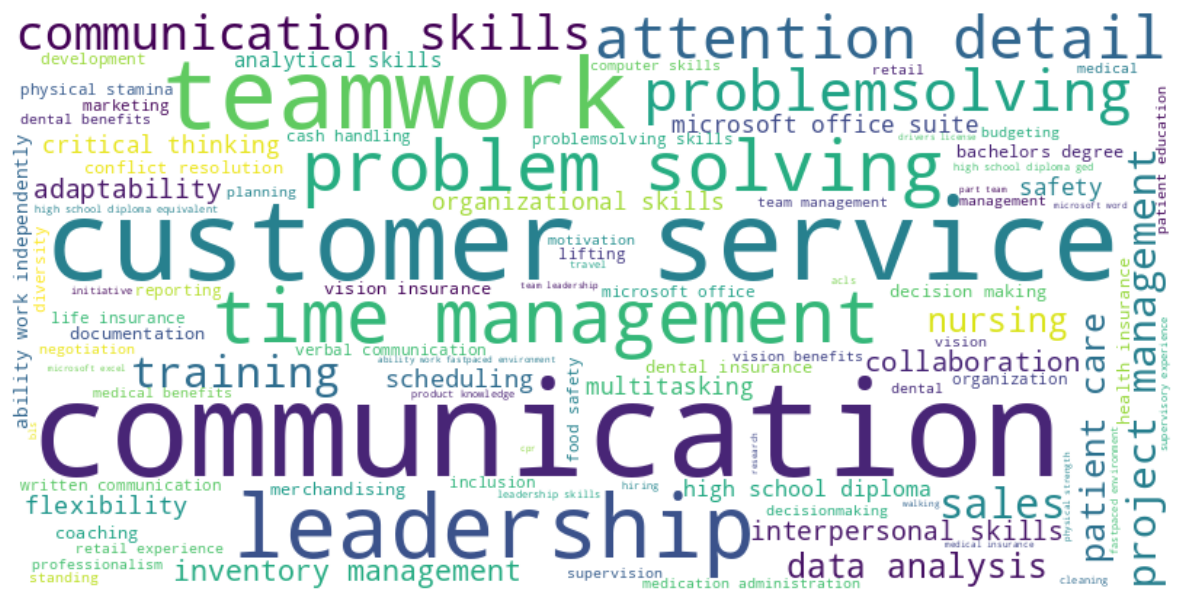

In [26]:
from collections import Counter


frequent_itemsets_ms = pd.read_csv(csv_file_path2)
frequent_itemsets_ms['itemset'] = frequent_itemsets_ms['itemset'].apply(lambda x: eval(x))
word_counter = Counter()
for _, row in frequent_itemsets_ms.iterrows():
    for item in row['itemset']:
        word_counter[item] += row['count']

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [27]:
spark.stop()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
